## Import the data

In [65]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
# import mplfinance as mpf
import yfinance as yf

plt.style.use('dark_background')
%matplotlib inline

symbol = "QQQ"

def load_ticker(sym, period="MAX", interval="1d"):
    spy = yf.Ticker(sym)
    print(spy.quarterly_balance_sheet.tail(10))
    return spy.history(period, interval).reset_index()
    
df = load_ticker(symbol)

print(df.info())
print(df.tail(10))

%store df
%store symbol

Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5351 entries, 0 to 5350
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5351 non-null   datetime64[ns]
 1   Open          5351 non-null   float64       
 2   High          5351 non-null   float64       
 3   Low           5351 non-null   float64       
 4   Close         5351 non-null   float64       
 5   Volume        5351 non-null   int64         
 6   Dividends     5351 non-null   float64       
 7   Stock Splits  5351 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 334.6 KB
None
           Date    Open    High     Low   Close    Volume  Dividends  \
5341 2020-06-01  232.46  234.45  232.00  234.06  25776000        0.0   
5342 2020-06-02  234.50  235.69  232.01  235.63  33383400        0.0   
5343 2020-06-03  236.26

## Plot the data to get an idea of the shape

0    26.30
1    26.49
Name: Close, dtype: float64
Stored 'df' (DataFrame)


<Figure size 864x864 with 0 Axes>

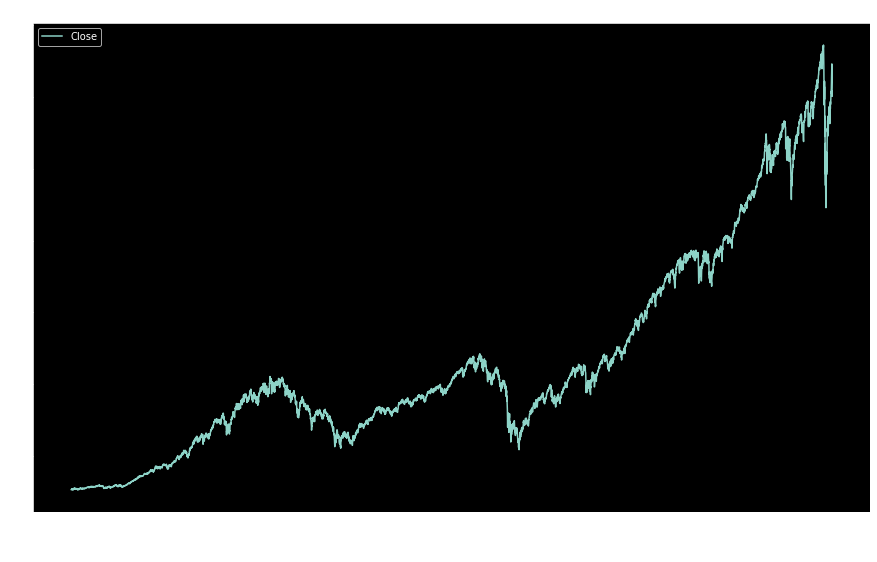

In [34]:
plt.figure(figsize=(12,12))
# plot the chart
df.plot(x="Date", y='Close', kind="line", title=f"{symbol} Close", figsize=(15,10))
plt.legend(loc="best")

print(df["Close"][0:2])

%store df

## apply indicators

/Users/eric/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/eric/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/eric/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/eric/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in double_scalars


Stored 'df' (DataFrame)


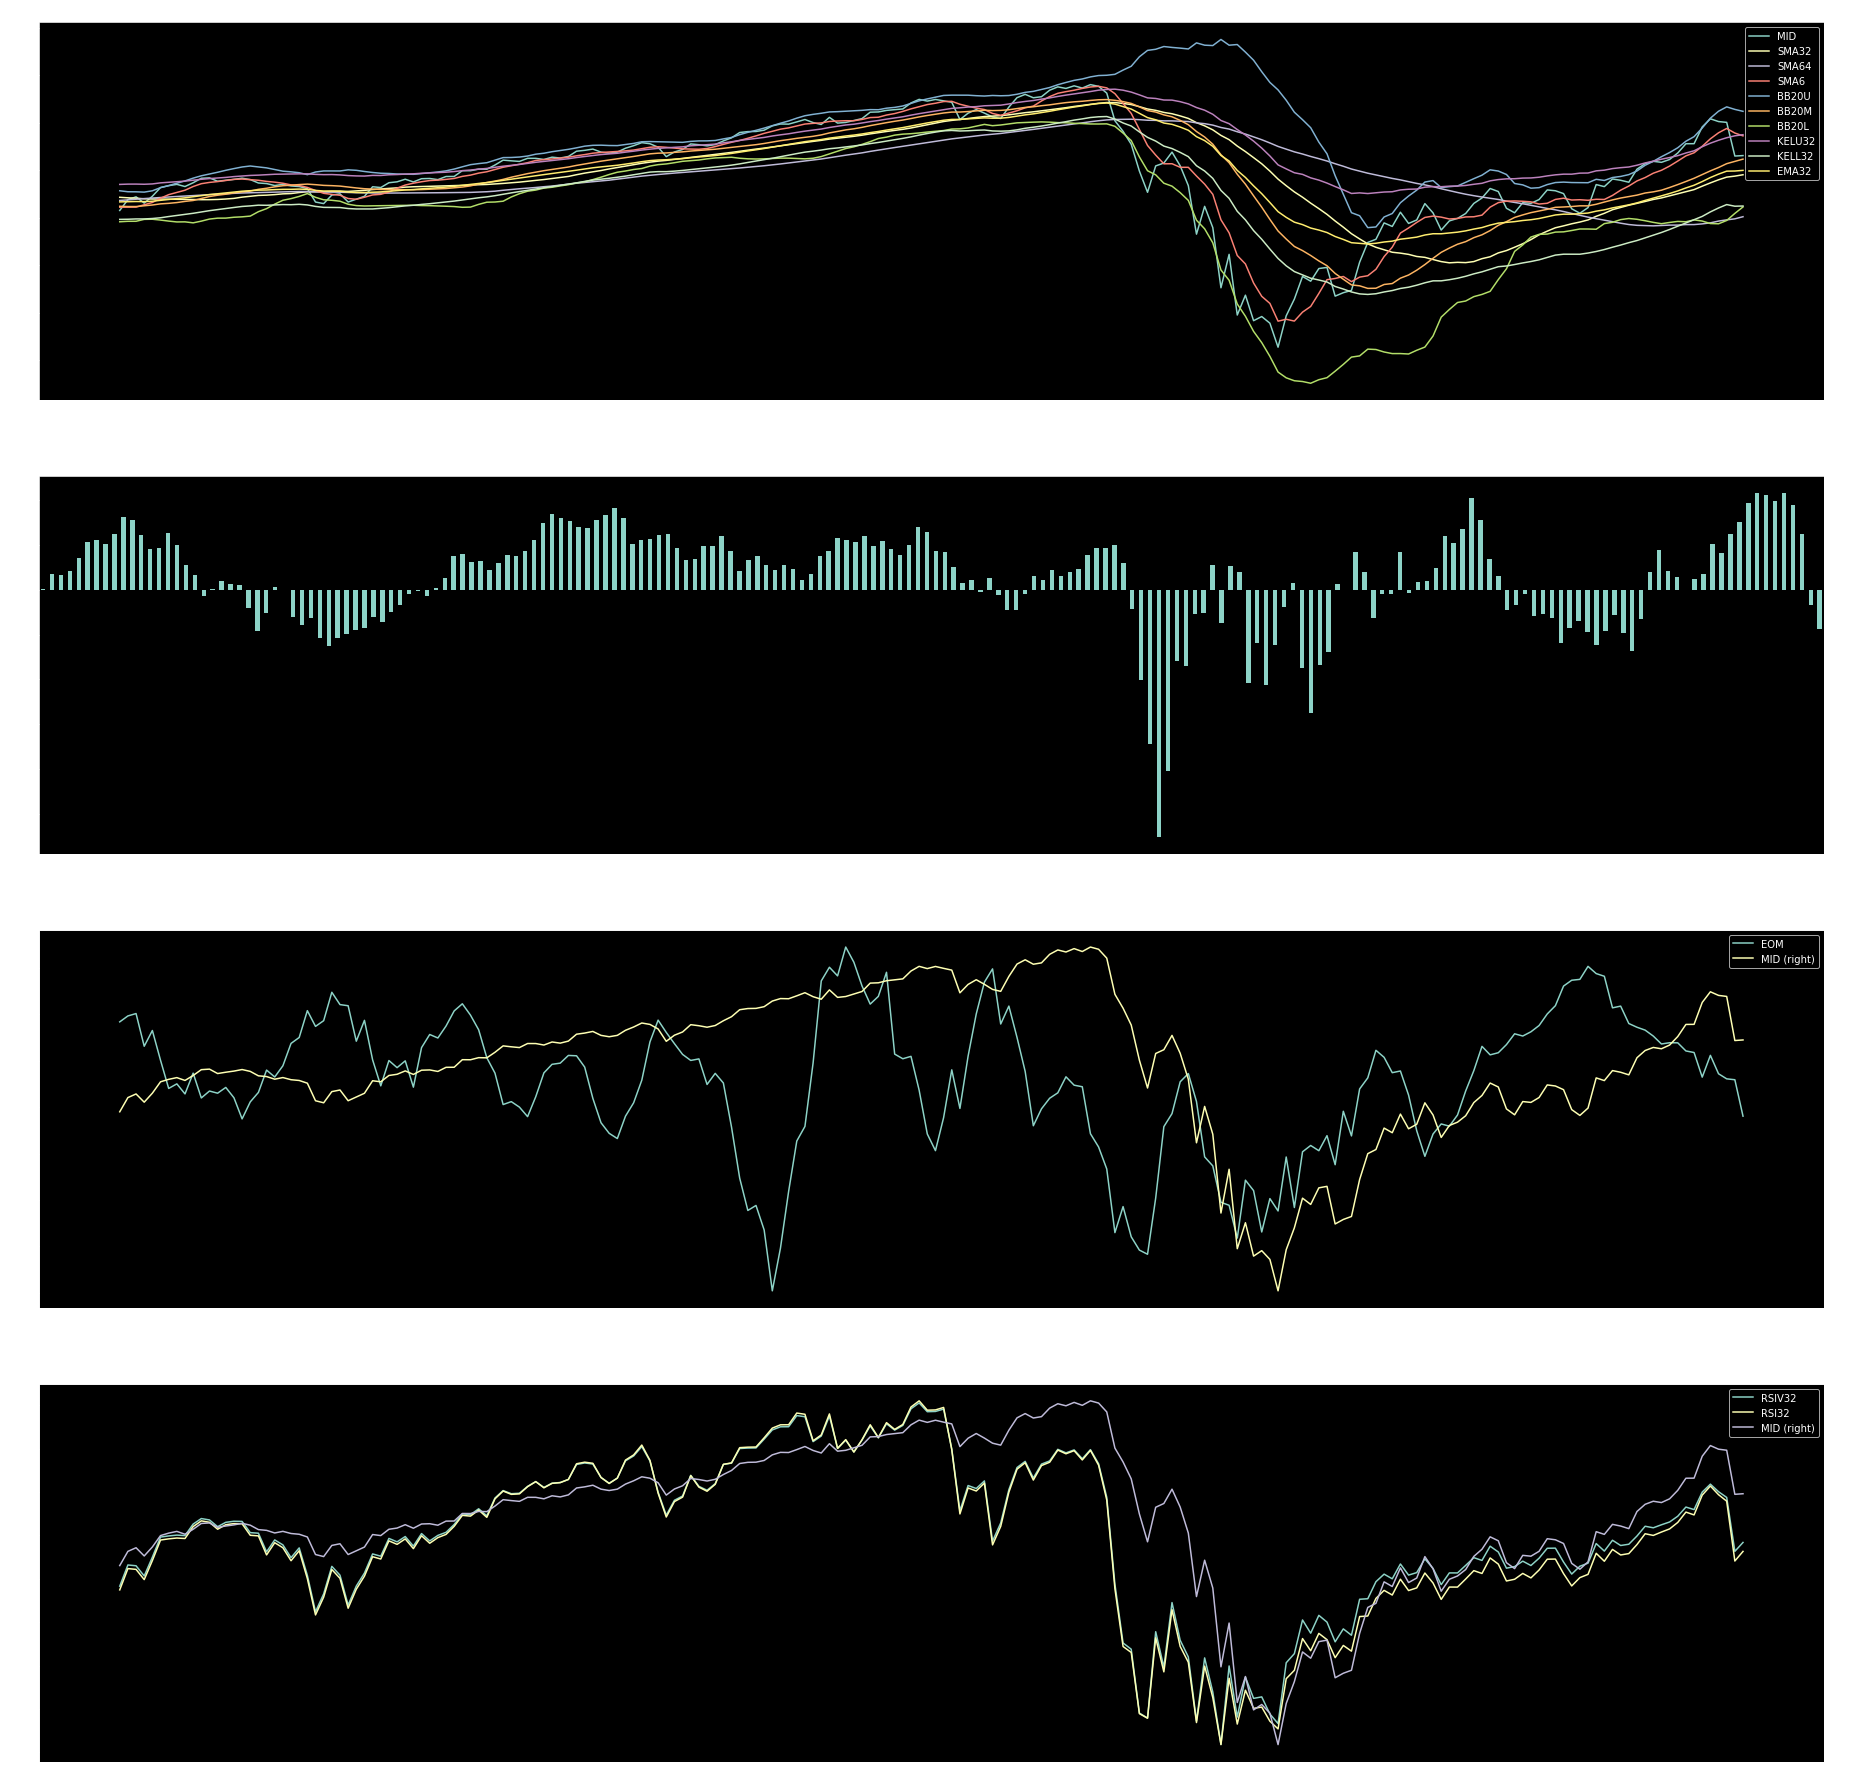

In [35]:
from talib import abstract
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from indicators import indicators as ind

SMA = abstract.SMA
BBANDS = abstract.BBANDS
RSI = abstract.RSI
ADOSC = abstract.ADOSC

def rsi_volume(volume, open, close, period=32):
    """
    :type volume: pd.Series
    :type open: pd.Series
    :type close: pd.Series
    :rtype: pd.Series
    """
    # todo: finish

    diff = close - open
    gains = pd.Series(index=volume.index)
    losses = pd.Series(index=volume.index)
    flow = pd.Series(index=volume.index)

    eom = ind.easy_of_movement(volume, open, close, period)

    avg_gain = 0
    avg_loss = 0

    for i in range(1, len(volume)):
        v = volume.iat[i]
        pv = volume.iat[-1]
        o = close.iat[i-1]
        c = close.iat[i]

        vchange = (v - pv) / v
        gain = 0
        loss = 0

        if c >= o: # this is a gain
            gain = (c - o) / o
            gains.iat[i] = (gain + eom.iat[i]) / 2
        else:  # this is a loss
            loss = abs((c - o) / o)
            losses.iat[i] = (loss + eom.iat[i]) / 2

        if i == period + 1:
            # first avgs
            avg_gain = gains.iloc[i-period:i].sum() / period
            avg_loss = losses.iloc[i-period:i].sum() / period
        else:
            avg_gain = (avg_gain * (period-1) + gain) / period
            avg_loss = (avg_loss * (period-1) + loss) / period

        # print(f"gain = {gain}\tloss={loss}\tavg_gain={avg_gain}\tavg_loss={avg_loss}\tvchange={vchange}")
        flow.iat[i] = (100 - (100/(1+(avg_gain/avg_loss))))
    return flow

def add_indicators(df):
    # apply indicators the the dataframe
    df["SMA64"] = pd.Series(SMA(df["Close"], timeperiod=64))  # type: pd.Series
    df["SMA32"] = pd.Series(SMA(df["Close"], timeperiod=32))  # type: pd.Series
    df["SMA6"] = pd.Series(SMA(df["Close"], timeperiod=6))  # type: pd.Series
    bbu, bbm, bbl = BBANDS(df["Close"], 32, 2., 2.)
    df["BB32U"], df["BB32M"], df["BB32L"] = (pd.Series(bbu), pd.Series(bbm), pd.Series(bbl))
    bbu, bbm, bbl = BBANDS(df["Close"], 20, 2., 2.)
    df["BB20U"], df["BB20M"], df["BB20L"] = (pd.Series(bbu), pd.Series(bbm), pd.Series(bbl))
    return df

df = add_indicators(df)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)

df["ADOSC"] = pd.Series(ADOSC(df["High"], df["Low"], df["Close"], df["Volume"], 3, 10))
df["RSI32"] = pd.Series(RSI(df["Close"], 32)) / 100
df["RSI6"] = pd.Series(RSI(df["Close"], 6)) / 100
df["MID"] = ind.mid_price(df["Open"], df["Close"])
df["TARGET"] = ind.percent_future_change(df)
df["AVGD"] = ind.avg_price_change(df["Open"], df["Close"])
df["EOM"] = ind.easy_of_movement(df["Volume"], df["Open"], df["Close"], 50).rolling(6).mean()
df["RSIV32"] = rsi_volume(df["Volume"], df["Open"], df["Close"], 32) / 100
df["KELU32"], df["KELL32"], df["EMA32"] = ind.keltner_channels(df["High"], df["Low"], df["Close"], 32)
df["SQZ"] = ind.squeeze(df["BB32U"], df["BB32L"], df["KELU32"], df["KELL32"]).astype(int)
chart_num = 200

# plot the dataframe with the indicators
df[[
    "MID",
    "SMA32",
    "SMA64",
    "SMA6",
    "BB20U",
    "BB20M",
    "BB20L",
    "KELU32",
    "KELL32",
    "EMA32",
]].tail(chart_num)\
    .plot(kind="line", title=f"{symbol} 5y Daily Mid", figsize=(32,32), ax=ax1)
df["ADOSC"].tail(chart_num).plot(kind="bar", ax=ax2, title="ADOSC")
# df["%volchange"].tail(chart_num).plot(ax=ax3, title="%vol change")
df[["EOM", "MID"]].tail(chart_num).plot(ax=ax3, title="easy_of_movement", secondary_y=["MID"])
df[["RSIV32", "RSI32", "MID"]].tail(chart_num).plot(ax=ax4, title="flow", secondary_y=["MID"])
%store df

## create synthetic values

/Users/eric/Projects/stonks/ml/indicators/indicators.py:349: RuntimeWarning: divide by zero encountered in double_scalars
  p.iat[i] = (diff.iat[i] - diff.iat[-1]) / diff.iat[i]
/Users/eric/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Stored 'df' (DataFrame)


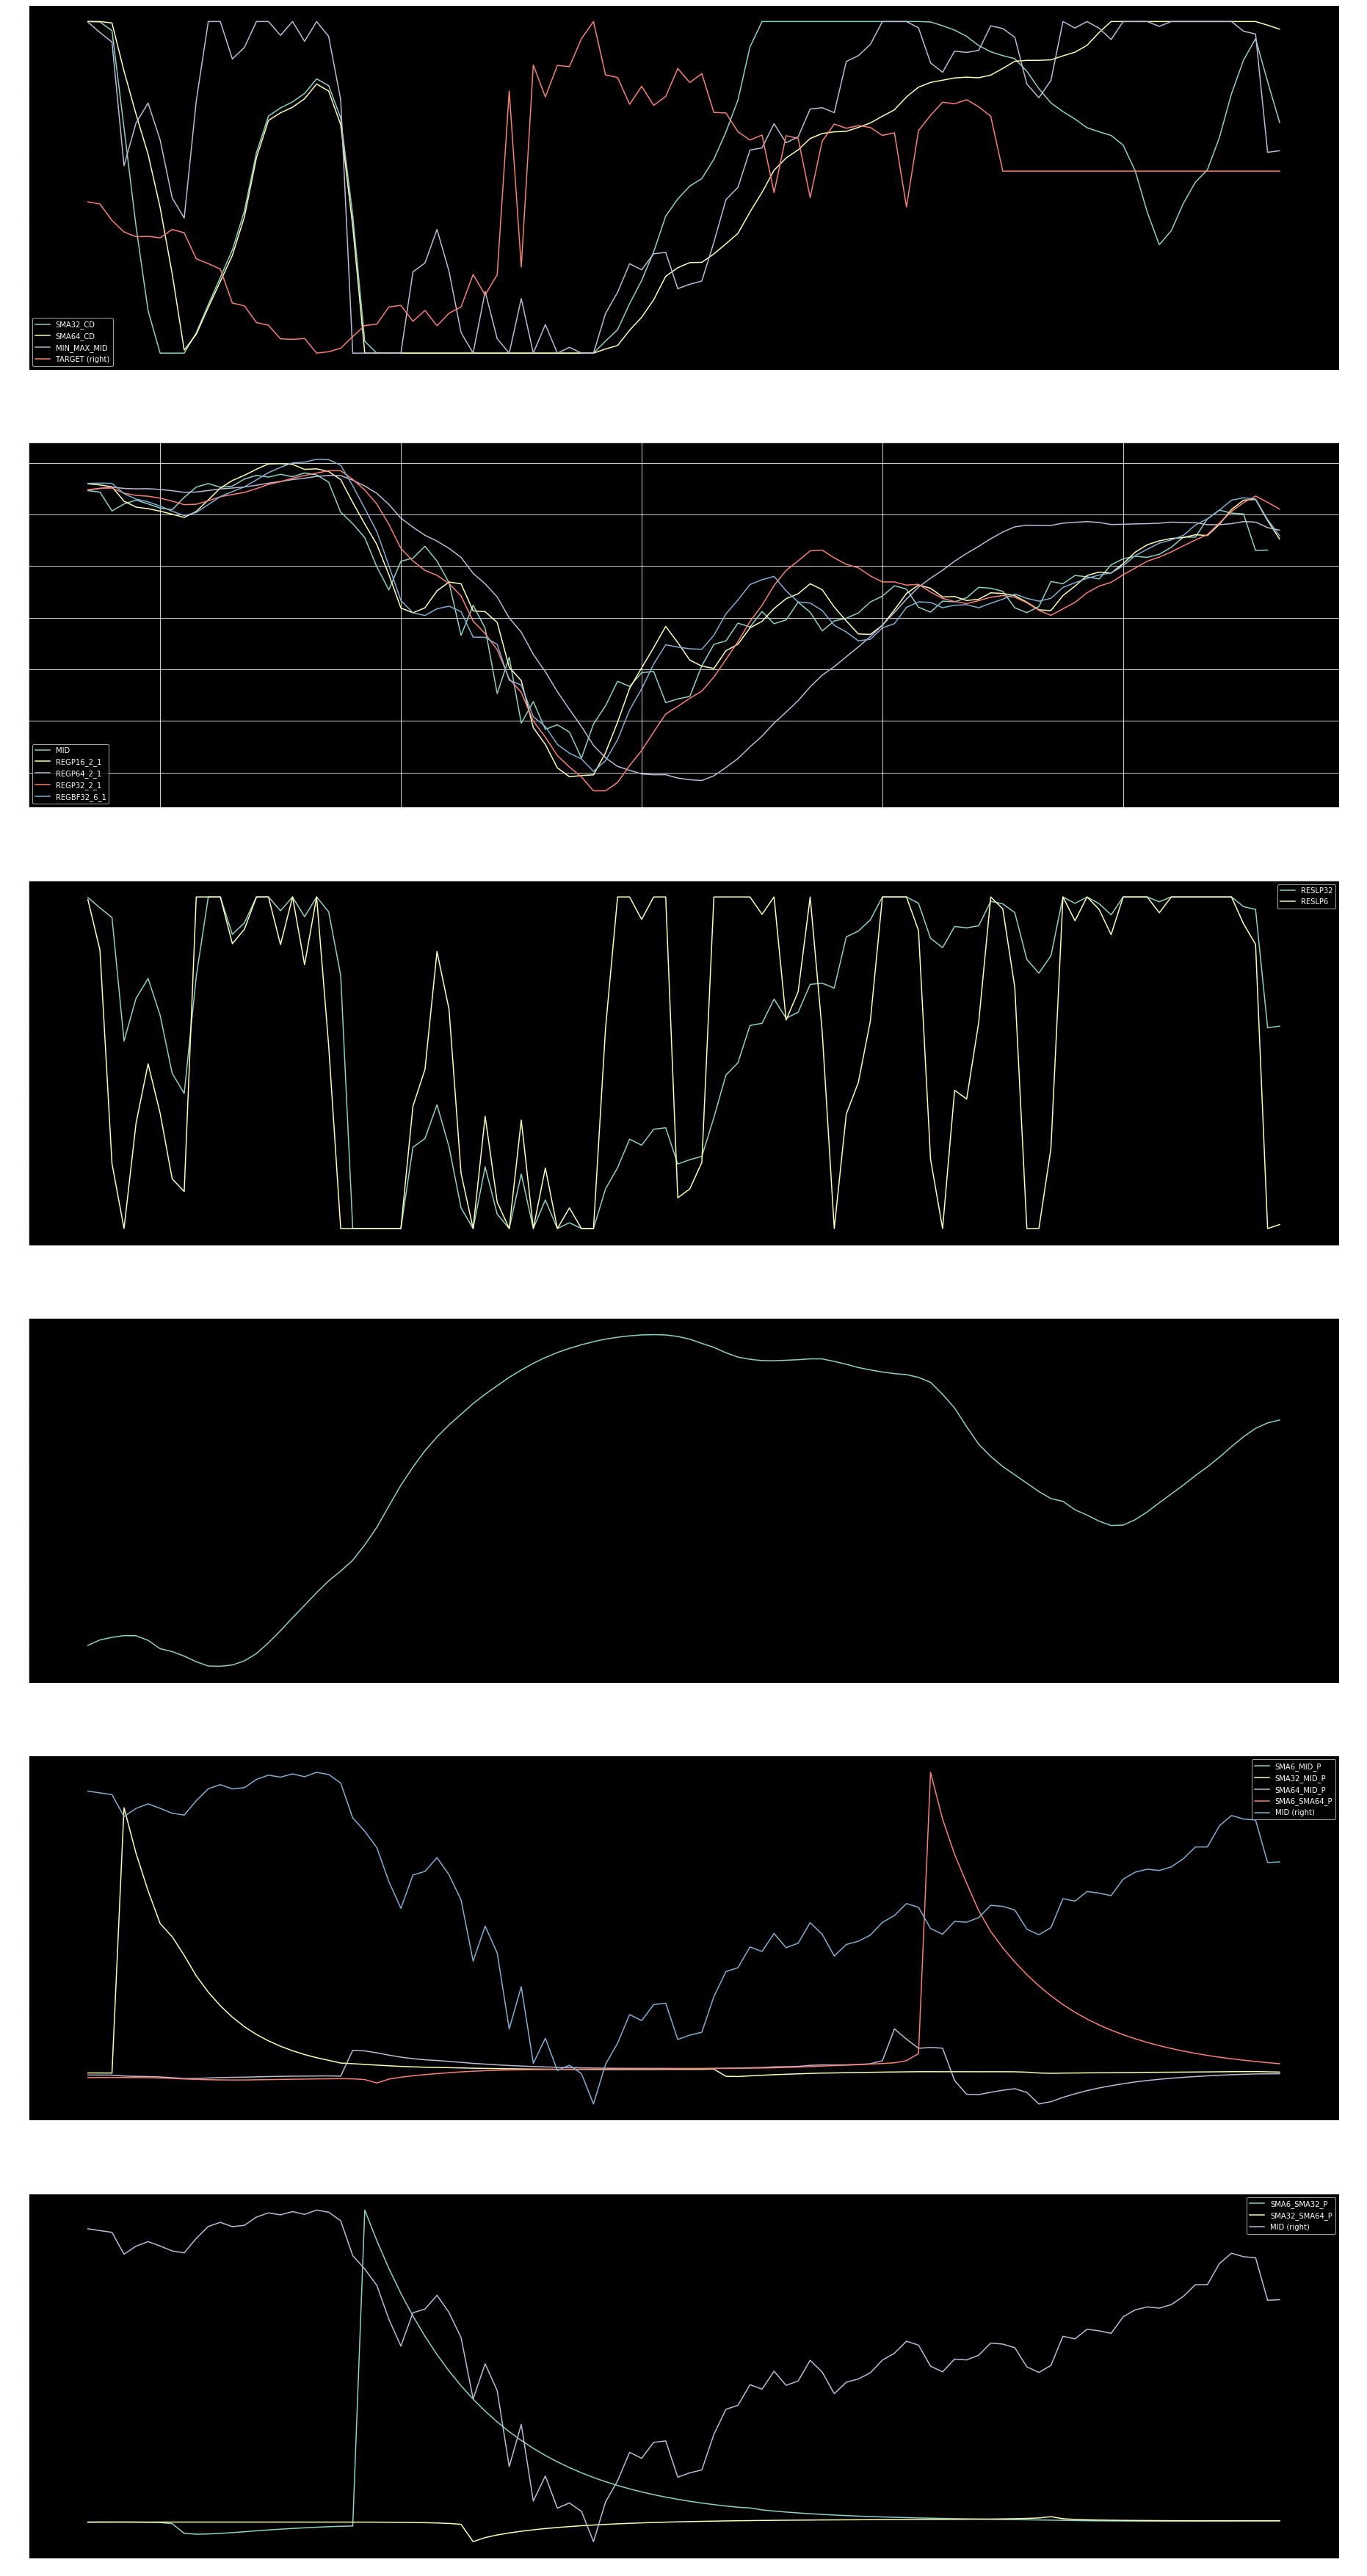

In [36]:
chart_num = 100

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

df["SMA6_CD"] = ind.convergence_divergence_min_max(df["MID"], df["SMA6"], 6, 0)
df["SMA32_CD"] = ind.convergence_divergence_min_max(df["MID"], df["SMA32"], 32)
df["SMA64_CD"] = ind.convergence_divergence_min_max(df["MID"], df["SMA64"], 64)
df["MIN_MAX_MID"] = ind.trend_min_max(df["MID"])

df["SMA6_MID_P"] = ind.difference_percentage_change(df["MID"], df["SMA6"], 6, 6)
df["SMA32_MID_P"] = ind.difference_percentage_change(df["MID"], df["SMA32"], 6, 32)
df["SMA64_MID_P"] = ind.difference_percentage_change(df["MID"], df["SMA64"], 6, 64)

df["SMA6_SMA32_P"] = ind.difference_percentage_change(df["SMA6"], df["SMA32"], 10, 32)
df["SMA32_SMA64_P"] = ind.difference_percentage_change(df["SMA32"], df["SMA64"], 10, 64)
df["SMA6_SMA64_P"] = ind.difference_percentage_change(df["SMA6"], df["SMA64"], 10, 64)

df["RESLP32"] = ind.regression_slope_min_max(df["MID"], 32)
df["RESLP6"] = ind.regression_slope_min_max(df["MID"], 6)
df["REG6"] = ind.rolling_regression(df["MID"], 6)
df["REGP6_2"] = ind.rolling_regression_poly(df["MID"], 6)
# predict 2 periods into the future
df["REGP16_2_1"] = ind.rolling_regression_poly(df["MID"], 16, 2, 1)
# df["regp_16_2_0"] = rolling_regression_poly(df["Close"], 16, 2, 0)
# df["regp_32_2_0"] = rolling_regression_poly(df["Close"], 32, 2, 0)
df["REGP32_2_1"] = ind.rolling_regression_poly(df["MID"], 32, 2, 1)
df["REGP64_2_1"] = ind.rolling_regression_poly(df["MID"], 64, 2, 1)
df["REGBF32_6_1"] = ind.rolling_best_fit_regression(df["MID"], 32, 6, 1)
df["BB20_CDP"] = ind.difference_percentage_change(df["BB20U"], df["BB20L"], 6, 20)

df[["SMA32_CD",
    "SMA64_CD",
    "MIN_MAX_MID",
    "TARGET"]].tail(chart_num).head(200).plot(title="", ax=ax1, secondary_y="TARGET")

chartDf = df[["MID", "REGP16_2_1", "REGP64_2_1", "REGP32_2_1", "REGBF32_6_1"]]
# add 1 blank rows to the chart
chartDf.loc[max(df.index) + 1, :] = None
chartDf["REGP64_2_1"] = chartDf["REGP64_2_1"].shift(1)
chartDf["REGP16_2_1"] = chartDf["REGP16_2_1"].shift(1)
chartDf["REGP32_2_1"] = chartDf["REGP32_2_1"].shift(1)
chartDf["REGBF32_6_1"] = chartDf["REGBF32_6_1"].shift(1)
chartDf.tail(chart_num).plot(title="regression", grid=True, figsize=(32,64), ax=ax2)

df[["RESLP32", "RESLP6"]].tail(chart_num).plot(title="regression slope", ax=ax3)
df["BB20_CDP"].tail(chart_num).plot(title="bbands % change", ax=ax4)

df[["SMA6_MID_P",
    "SMA32_MID_P",
    "SMA64_MID_P",
    "SMA6_SMA64_P",
    "MID"]].tail(chart_num).plot(title="SMA v MID Percentage Change", ax=ax5, secondary_y="MID")

df[["SMA6_SMA32_P",
    "SMA32_SMA64_P",
    "MID"]].tail(chart_num).plot(title="SMA v SMA Percentage Change", ax=ax6, secondary_y="MID")

%store df

## normalize the data for ML algos

In [64]:
from indicators import normalize as nm

pd.set_option('display.max_rows', 100)

output_file = os.path.join(os.getcwd(), "..", "data", f"{symbol}.csv")

# create the df that will be saved for training
out_df = pd.DataFrame(index=df.index)
out_df["TARGET"] = nm.discretize_series(df["TARGET"],
                                        # bins=(0, .2, .4, .6, .8, 1),
                                        bins=5,
                                        labels=("--", "-", "=", "+", "++"))
                                        # labels=False)
bins = (-.1, .1, .2, .3, .4, .5, .6, .7, .9, 1, 1.1)
labels = (.1, .2, .3, .4, .5, .6, .7, .8, .9, 1)

# DISCRETIZE ALL THE THINGS
out_df["EOM"] = pd.cut(df["EOM"], bins=bins, labels=labels, include_lowest=True)
out_df["SMA32_CD"] = pd.cut(df["SMA32_CD"], bins=bins, labels=labels, include_lowest=True)
out_df["SMA64_CD"] = pd.cut(df["SMA64_CD"], bins=bins, labels=labels, include_lowest=True)
out_df["MIN_MAX_MID"] = pd.cut(df["MIN_MAX_MID"], bins=bins, labels=labels, include_lowest=True)
out_df["RESLP32"] = pd.cut(df["RESLP32"], bins=bins, labels=labels, include_lowest=True)
out_df["BB20_CDP"] = pd.cut(df["BB20_CDP"], bins=bins, labels=labels, include_lowest=True)
out_df["BB20_CDP"] = pd.cut(df["BB20_CDP"], bins=bins, labels=labels, include_lowest=True)
out_df["RESLP32"] = pd.cut(df["RESLP32"], bins=bins, labels=labels, include_lowest=True)
out_df["RESLP6"] = pd.cut(df["RESLP6"], bins=bins, labels=labels, include_lowest=True)
out_df["BB20_CDP"] = pd.cut(df["BB20_CDP"].rolling(20).apply(nm.min_max), bins=bins, labels=labels, include_lowest=True)
out_df["RSIV32"] = pd.cut(df["RSIV32"], bins=bins, labels=labels, include_lowest=True)
# signal boolean columns
out_df["SQZ"] = df["SQZ"]
# relationship boolean columns
out_df["REGP6_GTE_MID"] = (df["REGP6_2"] >= df["MID"]).astype(int)
out_df["REGP32_GTE_MID"] = (df["REGP32_2_1"] >= df["MID"]).astype(int)
out_df["REGP64_GTE_MID"] = (df["REGP64_2_1"] >= df["MID"]).astype(int)
out_df["SMA6_GTE_SMA32"] = (df["SMA6"] >= df["SMA32"]).astype(int)
out_df["SMA32_GTE_SMA64"] = (df["SMA32"] >= df["SMA64"]).astype(int)
out_df["SMA6_GTE_MID"] = (df["SMA6"] >= df["MID"]).astype(int)
out_df["SMA32_GTE_MID"] = (df["SMA32"] >= df["MID"]).astype(int)
out_df["SMA64_GTE_MID"] = (df["SMA64"] >= df["MID"]).astype(int)
out_df["EMA32_GTE_SMA32"] = (df["EMA32"] >= df["SMA32"]).astype(int)
out_df["HIGH_GTE_BB20U"] = (df["High"] >= df["BB20U"]).astype(int)
out_df["LOW_LTE_BB20L"] = (df["Low"] <= df["BB20L"]).astype(int)
# directional boolean columns
out_df["REGP6+"] = (df["REGP6_2"] >= df["REGP6_2"].shift(-1)).astype(int)
out_df["REGP32+"] = (df["REGP32_2_1"] >= df["REGP32_2_1"].shift(-1)).astype(int)
out_df["SMA6+"] = (df["SMA6"] >= df["SMA6"].shift(-1)).astype(int)
out_df["SMA32+"] = (df["SMA32"] >= df["SMA32"].shift(-1)).astype(int)
out_df["SMA64+"] = (df["SMA64"] >= df["SMA64"].shift(-1)).astype(int)
out_df["EOM+"] = (df["EOM"] >= df["EOM"].shift(-1)).astype(int)
out_df["MID+"] = (df["MID"] >= df["MID"].shift(-1)).astype(int)
out_df["HIGH+"] = (df["High"] >= df["High"].shift(-1)).astype(int)
out_df["LOW+"] = (df["Low"] >= df["Low"].shift(-1)).astype(int)
out_df["CLOSE"] = (df["Close"] >= df["Close"].shift(-1)).astype(int)
print(out_df.tail(100))
# drop NA rows, and write to csv
out_df.dropna().to_csv(output_file, index=False)

     TARGET  EOM SMA32_CD SMA64_CD MIN_MAX_MID RESLP32 BB20_CDP RESLP6 RSIV32  \
6793      =  0.5      0.9      0.9         0.9     0.9      0.7    0.9    0.7   
6794      =  0.5      0.9      0.9         0.9     0.9      0.7    0.8    0.7   
6795      =  0.5      0.9      0.9         0.9     0.9      0.6    0.2    0.7   
6796      -  0.5      0.7      0.8         0.6     0.6      0.5    0.1    0.6   
6797      -  0.6      0.4      0.8         0.7     0.7      0.5    0.4    0.7   
6798      -  0.6      0.2      0.6         0.8     0.8      0.4    0.5    0.7   
6799      -  0.6      0.1      0.5         0.7     0.7      0.2    0.4    0.7   
6800      -  0.6      0.1      0.3         0.5     0.5      0.1    0.2    0.6   
6801      -  0.6      0.1      0.1         0.5     0.5      0.1    0.2    0.6   
6802      -  0.6      0.1      0.1         0.8     0.8      0.1    0.9    0.7   
6803      -  0.6      0.2      0.2         0.9     0.9      0.1    0.9    0.7   
6804      -  0.5      0.3   

## Base Line P/Ls

import copy

trades = pd.DataFrame(columns=["index", "open_price", "direction", "periods", "+/-", "p/l"])

pos = {
    "index": 0,
    "periods": 0,
    "p/l": 0,
}

open_position = None

rows = []

num_buys = 10
CMP = "SMA6"

# test trading  based on cvd
for i, row in df.iterrows():
    if open_position is not None:
        open_position["periods"] += 1
        if open_position["direction"] == "long":
            open_position["p/l"] = (row["Close"] - open_position["open_price"]) * num_buys
        else: 
            open_position["p/l"] = (open_position["open_price"] - row["Close"]) * num_buys

    if row["reg"] > row[CMP] and df[CMP][i-1] > df["reg"][i-1] \
            and row["reg_slope"] > 0:
    # if row["reg"] > row[CMP] and df[CMP][i-1] > df["reg"][i-1] and row["reg_slope"] > 0:
    # if row["sma32_cvd"] < -0.9:
        if open_position is not None and i > 1:
            open_position["close_price"] = row["Close"]
            rows.append(copy.copy(open_position))
            open_position = None
        open_position = {
            "open_price": row["Close"],
            "direction": "long",
            "index": i,
            "periods": 0,
            "p/l": 0,
        }
            
    # elif row["reg"] < row[CMP] and df[CMP][i-1] < df["reg"][i-1] and row["reg_slope"] < 0  and row["sma32_cvd"] > 0:
    elif row["reg"] < row[CMP] and df[CMP][i-1] < df["reg"][i-1] \
            and row["reg_slope"] < 0:
        
        if open_position is not None and i > 1:
            open_position["close_price"] = row["Close"]
            rows.append(copy.copy(open_position))
            open_position = None
            
        open_position = {
            "open_price": row["Close"],
            "direction": "short",
            "index": i,
            "periods": 0,
            "p/l": 0,
        }
        
    if open_position is not None:
        if open_position["direction"] == "long" \
                and row["reg"] < row[CMP] and df[CMP][i-1] < df["reg"][i-1]:
        # if row["sma32_cvd"] > 0.5:
            open_position["close_price"] = row["Close"]
            rows.append(copy.copy(open_position))
            open_position = None
        
        elif open_position["direction"] == "short" \
                and row["reg"] > row[CMP] and df[CMP][i-1] > df["reg"][i-1]:
           open_position["close_price"] = row["Close"]
           rows.append(copy.copy(open_position))
           open_position = None

trades = pd.DataFrame(rows)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(trades)
    print(trades["p/l"].sum())
    print(trades[trades["p/l"] > 0]["p/l"].count())